# libs 

In [54]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
# pyarrow 
import pyarrow.parquet as pq


### Simulation Scenarios Must Include:  
- Heavy rain
- Temperature extremes
- High humidity
- Low visibility
- Strong winds  
### Main Outputs:  
-  Probability of:  
    -  Traffic jams
    -  Accident risk under bad weather
    -  Distribution of congestion probabilities from thousands of simulation runs

In [55]:
data = pd.read_parquet("../clean_data/merged_data.parquet",engine="pyarrow",dtype_backend="pyarrow")

In [56]:
data.head()

,traffic_id,date_time,city,area,vehicle_count,avg_speed_kmh,accident_count,congestion_level,road_condition,visibility_m_x,weather_id,season,temperature_c,humidity,rain_mm,wind_speed_kmh,visibility_m_y,weather_condition,air_pressure_hpa
0,5,2024-01-01 04:00:00,London,Chelsea,3748,107.906517,2,Low,Snowy,8711,5,Summer,15.360175,91.0,16.867431,24.270452,4666,Rain,951.177326
1,8,2024-01-01 07:00:00,London,Kensington,3218,95.727944,6,Medium,Snowy,6887,8,Spring,17.661852,59.0,9.826941,78.793561,1508,Clear,1033.559398
2,9,2024-01-01 08:00:00,London,Kensington,259,88.98006,1,High,Dry,1372,9,Winter,12.073337,50.0,26.247984,62.388994,2597,Snow,956.031503
3,10,2024-01-01 09:00:00,London,Chelsea,1404,36.028368,1,Medium,Dry,3294,10,Winter,8.638003,18.0,16.867431,45.055543,6285,Fog,963.563889
4,11,2024-01-01 10:00:00,London,Camden,41,72.182852,0,High,Snowy,3225,11,Winter,9.430213,92.0,24.425748,68.345731,7919,Clear,960.12186


In [57]:
data.columns , data.shape

(Index(['traffic_id', 'date_time', 'city', 'area', 'vehicle_count',
        'avg_speed_kmh', 'accident_count', 'congestion_level', 'road_condition',
        'visibility_m_x', 'weather_id', 'season', 'temperature_c', 'humidity',
        'rain_mm', 'wind_speed_kmh', 'visibility_m_y', 'weather_condition',
        'air_pressure_hpa'],
       dtype='object'),
 (1512, 19))

1. Define a Model that represent the process: Empirical Monte Carlo
2. Specify Probability Distributions: Bernoulli Distribution and Normal Distribution
3. Generate Random Samples: Done
4. Run the simulation: Done
5. Analysis the simulation  

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype                 
---  ------             --------------  -----                 
 0   traffic_id         1512 non-null   int64[pyarrow]        
 1   date_time          1512 non-null   timestamp[ns][pyarrow]
 2   city               1512 non-null   string[pyarrow]       
 3   area               1512 non-null   string[pyarrow]       
 4   vehicle_count      1512 non-null   int64[pyarrow]        
 5   avg_speed_kmh      1512 non-null   double[pyarrow]       
 6   accident_count     1512 non-null   int64[pyarrow]        
 7   congestion_level   1512 non-null   string[pyarrow]       
 8   road_condition     1512 non-null   string[pyarrow]       
 9   visibility_m_x     1512 non-null   int64[pyarrow]        
 10  weather_id         1512 non-null   int64[pyarrow]        
 11  season             1512 non-null   string[pyarrow]       
 12  temper

In [59]:
print(data["city"].value_counts())
print(data["area"].value_counts())
print(data["congestion_level"].value_counts())
print(data["road_condition"].value_counts())

city
London    1512
Name: count, dtype: int64[pyarrow]
area
Chelsea       571
Southwark     258
Kensington    233
Islington     226
Camden        224
Name: count, dtype: int64[pyarrow]
congestion_level
Low       799
High      357
Medium    356
Name: count, dtype: int64[pyarrow]
road_condition
Wet        634
Dry        322
Snowy      285
Damaged    271
Name: count, dtype: int64[pyarrow]


In [60]:
print(data["season"].value_counts())
print(data["weather_condition"].value_counts())

season
Autumn    658
Winter    294
Summer    281
Spring    279
Name: count, dtype: int64[pyarrow]
weather_condition
Rain     531
Storm    252
Snow     250
Clear    242
Fog      237
Name: count, dtype: int64[pyarrow]


In [61]:
traffic_col = ["traffic_id", "date_time","city", "area", "vehicle_count", "avg_speed_kmh", "accident_count", "congestion_level", "road_condition", "visibility_m_x"]
weather_col = ["weather_id", "season", "temperature_c", "humidity", "rain_mm", "wind_speed_kmh", "visibility_m_y", "weather_condition", "air_pressure_hpa"]

## Data Generation

In [62]:
mapping = {'Low': 0, 'Medium': 1, 'High': 2}
data['congestion_score'] = data['congestion_level'].map(mapping)
data['has_accident'] = (data['accident_count'] > 0).astype(int)
data['is_jam'] = (data['congestion_score'] >= 1).astype(int)
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
numeric_cols

['traffic_id',
 'vehicle_count',
 'avg_speed_kmh',
 'accident_count',
 'visibility_m_x',
 'weather_id',
 'temperature_c',
 'humidity',
 'rain_mm',
 'wind_speed_kmh',
 'visibility_m_y',
 'air_pressure_hpa',
 'congestion_score',
 'has_accident',
 'is_jam']

In [63]:
cat_col = ["season", "weather_condition", "road_condition", "congestion_level"]
num_col = ["temperature_c", "humidity", "rain_mm", "wind_speed_kmh", "visibility_m_y", "air_pressure_hpa", "vehicle_count", "avg_speed_kmh", "accident_count", "visibility_m_x"]

In [64]:
# generate new day
def generate_new_day(n_days=1):
    probs = data['weather_condition'].value_counts(normalize=True)
    sim_weather = np.random.choice(probs.index, size=n_days, p=probs.values)
    sim_df = pd.DataFrame({'weather_condition': sim_weather})

    for condition in np.unique(sim_weather):
        mask = sim_df['weather_condition'] == condition
        history = data[data['weather_condition'] == condition]
        for col in num_col:
            kde = stats.gaussian_kde(history[col])
            simulated_kde = kde.resample(size=mask.sum()).T.flatten()
            simulated_kde = np.maximum(simulated_kde, 0)
            sim_df.loc[mask, col] = simulated_kde
        for col in cat_col:
            probs = history[col].value_counts(normalize=True)
            sim_df.loc[mask, col] = np.random.choice(probs.index, size=mask.sum(), p=probs.values)
    
    return sim_df

In [65]:
test = generate_new_day(1000)
test.head()

,weather_condition,temperature_c,humidity,rain_mm,wind_speed_kmh,visibility_m_y,air_pressure_hpa,vehicle_count,avg_speed_kmh,accident_count,visibility_m_x,season,road_condition,congestion_level
0,Fog,14.018470,74.955298,18.897948,55.086731,7204.708020,1025.422155,2034.046503,83.287797,7.772748,3320.495593,Autumn,Snowy,High
1,Rain,23.013658,52.016953,19.066823,41.976457,6022.950966,952.182114,3236.354617,72.446637,5.251564,4920.904792,Winter,Dry,Medium
2,Rain,9.071379,82.575921,17.208285,17.640243,5693.540315,972.541346,1373.610840,25.582697,5.039983,0.000000,Autumn,Dry,Low
3,Storm,7.618995,59.004256,6.932454,0.546223,4514.100783,1003.870877,4553.259182,1.402179,5.615546,8751.042490,Autumn,Damaged,High
4,Fog,18.933913,82.971470,19.113332,12.340740,8115.753025,998.974766,1366.616605,109.249127,2.725493,9889.368204,Autumn,Snowy,Low


## Calculations

In [66]:
data['scenario_id'] = data['weather_condition'] + "_" + data['road_condition']

risk_table = data.groupby('scenario_id')[numeric_cols].agg({
    'is_jam': 'mean',
    'has_accident': 'mean',
    'congestion_score': ['mean', 'std']
}).reset_index()

In [67]:
risk_table.columns = ['scenario_id', 'prob_jam_base', 'prob_accident_base', 'congestion_mean', 'congestion_std']
print(risk_table)

      scenario_id  prob_jam_base  prob_accident_base  congestion_mean  \
0   Clear_Damaged       0.454545            0.977273         0.659091   
1       Clear_Dry       0.415094            0.867925         0.641509   
2     Clear_Snowy       0.409091            0.886364         0.613636   
3       Clear_Wet       0.514851            0.940594         0.762376   
4     Fog_Damaged       0.418605            0.953488         0.651163   
5         Fog_Dry       0.500000            0.980769         0.730769   
6       Fog_Snowy       0.500000            0.934783         0.739130   
7         Fog_Wet       0.531250            0.854167         0.864583   
8    Rain_Damaged       0.462366            0.935484         0.688172   
9        Rain_Dry       0.455446            0.940594         0.683168   
10     Rain_Snowy       0.367925            0.905660         0.500000   
11       Rain_Wet       0.510823            0.913420         0.744589   
12   Snow_Damaged       0.442308            0.92307

In [68]:
sim_df = generate_new_day(10000)
sim_df['scenario_id'] = sim_df['weather_condition'] + "_" + sim_df['road_condition']
sim_with_risk = sim_df.merge(risk_table, on='scenario_id', how='left')

# sim_with_risk.fillna({
#     'prob_jam_base': data['is_jam'].mean(), 
#     'prob_accident_base': data['has_accident'].mean(),
#     'congestion_mean': data['congestion_score'].mean(),
#     'congestion_std': 1.0
# }, inplace=True)

# Did a Jam happen? (Bernoulli Trial)
random_rolls = np.random.rand(len(sim_with_risk))
sim_with_risk['jam_occurred'] = random_rolls < sim_with_risk['prob_jam_base']

# Did an Accident happen? (Bernoulli Trial)
random_rolls_acc = np.random.rand(len(sim_with_risk))
sim_with_risk['accident_occurred'] = random_rolls_acc < sim_with_risk['prob_accident_base']

# Congestion Score (Continuous)
sim_with_risk['simulated_congestion_level'] = np.random.normal(
    loc=sim_with_risk['congestion_mean'], 
    scale=sim_with_risk['congestion_std']
)

In [69]:
total_jam_prob = sim_with_risk['jam_occurred'].mean()
print(f"1. Overall Probability of Traffic Jams: {total_jam_prob:.2%}")


# Filter for Bad Weather (e.g., Rain > 0 or Bad Visibility)
bad_weather_mask = (sim_with_risk['rain_mm'] > 0) | (sim_with_risk['visibility_m_y'] < 2000)
bad_weather_risk = sim_with_risk.loc[bad_weather_mask, 'accident_occurred'].mean()

print(f"2. Accident Risk under Bad Weather: {bad_weather_risk:.2%}")

1. Overall Probability of Traffic Jams: 47.68%
2. Accident Risk under Bad Weather: 91.94%


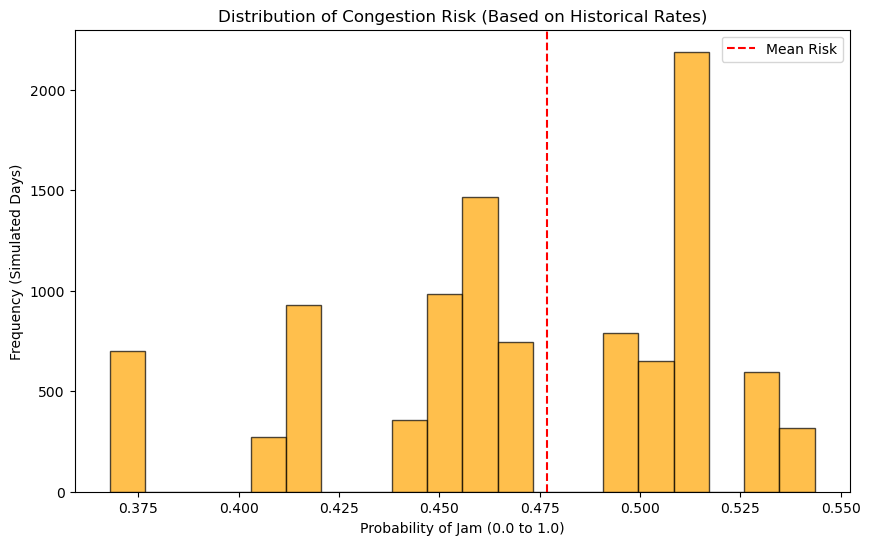

In [70]:
plt.figure(figsize=(10, 6))

# The Risk Profile
# This shows how many days fell into "High Risk" vs "Low Risk" categories
plt.hist(sim_with_risk['prob_jam_base'], bins=20, color='orange', edgecolor='black', alpha=0.7)

plt.title("Distribution of Congestion Risk (Based on Historical Rates)")
plt.xlabel("Probability of Jam (0.0 to 1.0)")
plt.ylabel("Frequency (Simulated Days)")
plt.axvline(total_jam_prob, color='red', linestyle='dashed', label='Mean Risk')
plt.legend()
plt.show()

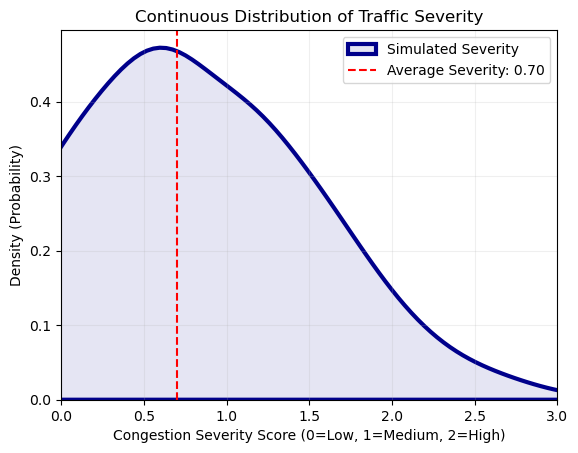

In [71]:
sns.kdeplot(sim_with_risk['simulated_congestion_level'], 
            color='darkblue', 
            linewidth=3, 
            fill=True, 
            alpha=0.1, 
            bw_adjust=1.5,
            label='Simulated Severity')


mean_val = sim_with_risk['simulated_congestion_level'].mean()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Average Severity: {mean_val:.2f}')


plt.title("Continuous Distribution of Traffic Severity")
plt.xlabel("Congestion Severity Score (0=Low, 1=Medium, 2=High)")
plt.ylabel("Density (Probability)")
plt.xlim(0, 3) # Limit x-axis to realistic scores
plt.legend()
plt.grid(alpha=0.2)

plt.show()